In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

In [10]:
df =  pd.read_csv('/kaggle/input/energy/2yrs_data.csv')

In [11]:
data = df.copy()
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
#data.set_index('Datetime', inplace=True)

# # Resample data to hourly frequency and compute the sum
# hourly_data = df['Global_active_power'].resample('H').sum().reset_index()
# hourly_data.rename(columns={'Global_active_power': 'Hourly_Sum'}, inplace=True)

# scaler = MinMaxScaler(feature_range=(0, 1))
# data_scaled = scaler.fit_transform(hourly_data['Hourly_Sum'].values.reshape(-1, 1))


df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour  
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute 
df['Day'] = pd.to_datetime(df['Date']).dt.day                      
df['Month'] = pd.to_datetime(df['Date']).dt.month                 
df['Year'] = pd.to_datetime(df['Date']).dt.year  

df['hourly_active_power'] = df.groupby(['Year','Month','Day','Hour'])['Global_active_power'].transform('sum')
df = df.drop(columns=['Date', 'Time','Minute','Global_active_power','Global_reactive_power','Global_intensity','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3'],).reset_index()
df = df.drop(columns=['index']).drop_duplicates().reset_index(drop=True)

scaler = StandardScaler()
df['hourly_active_power'] = scaler.fit_transform(df[['hourly_active_power']])


In [12]:
class MultiStepTimeSeriesGenerator():
    """
    Modified to only create train and test datasets.
    """

    def __init__(self, 
                 input_width, 
                 label_width, 
                 shift,
                 df,
                 batch_size,
                 train_ratio=0.8):
        
        # Ensure train ratio is valid
        assert 0.0 < train_ratio < 1.0, "Train ratio must be between 0 and 1."

        # Work out the window parameters
        self.input_width       = input_width
        self.label_width       = label_width
        self.shift             = shift
        self.batch_size        = batch_size
        self.total_window_size = input_width + label_width
        self.input_slice       = slice(0, input_width)
        self.labels_slice      = slice(self.total_window_size - self.label_width, None)

        # Calculate dataset split indices
        total_data = len(df) - (input_width + label_width)
        train_end = int(total_data * train_ratio)

        # Split the data
        self.train_df = df[:train_end]
        self.test_df = df[train_end:]

        # Create datasets
        self.train = self.make_dataset(self.train_df)
        self.test = self.make_dataset(self.test_df)

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        labels = tf.stack([labels[:, :, 0]], axis=-1)
    
        # Slicing doesn't preserve static shape information, so set the shapes manually
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(data=data,
                                                          targets=None,
                                                          sequence_length=self.total_window_size,
                                                          sequence_stride=1,
                                                          shuffle=False,
                                                          batch_size=self.batch_size)

        ds = ds.map(self.split_window)

        return ds

In [13]:
# Parameters
N_STEPS_IN = 5
N_STEPS_OUT = 5
N_EPOCHS = 20
BATCH_SIZE = 16

# Create generator
time_series_dataset = MultiStepTimeSeriesGenerator(
    input_width=N_STEPS_IN, 
    label_width=N_STEPS_OUT, 
    shift=1, 
    df=df, 
    batch_size=BATCH_SIZE,
    train_ratio=0.8  # 80% train, 20% test
)

# Access datasets
train_data = time_series_dataset.train
test_data = time_series_dataset.test

# Print dataset info
print(f"Train size: {len(time_series_dataset.train_df)}")
print(f"Test size: {len(time_series_dataset.test_df)}")

Train size: 14271
Test size: 3578


In [19]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(N_STEPS_IN, 1)),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(N_STEPS_OUT)
])

# Compile model
optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)  # Clip gradients
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Create datasets from dataframe
time_series_dataset = MultiStepTimeSeriesGenerator(
    input_width=N_STEPS_IN,
    label_width=N_STEPS_OUT,
    shift=12,
    df=df[['hourly_active_power']],
    batch_size=BATCH_SIZE,
    train_ratio=0.8  # Train-test split
)

# Remove validation references in callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    time_series_dataset.train,
    epochs=100,  # Increase epochs for better convergence
    verbose=1,
    callbacks=[early_stopping, reduce_lr],  # Monitor training loss
    shuffle=False
)

# Evaluate the model on the test set
test_predictions = model.predict(time_series_dataset.test, verbose=0)

# Prepare the test labels
test_labels = np.concatenate(
    [batch[1] for batch in time_series_dataset.test.as_numpy_iterator()], axis=0
)

# Reshape predictions and labels
test_predictions = np.squeeze(test_predictions)
test_labels = np.squeeze(test_labels)

# Calculate metrics
test_mse = mean_squared_error(test_labels, test_predictions)
mape = np.mean(np.abs((test_labels - test_predictions) / (test_labels + 1e-6))) * 100  # Avoid division-by-zero
r2 = r2_score(test_labels, test_predictions)
test_rmse = np.sqrt(test_mse)

# Print metrics
print(f"Test MSE: {test_mse:.5f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.5f}")
print(f"Test RMSE: {test_rmse:.5f}")

Epoch 1/100


I0000 00:00:1733354295.736437     103 service.cc:145] XLA service 0x5a15239e86f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733354295.736501     103 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733354295.736507     103 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 50/892 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8454 - mae: 1.0963

I0000 00:00:1733354300.068368     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


892/892 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 1.1831 - mae: 0.8643 - learning_rate: 5.0000e-04
Epoch 2/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0963 - mae: 0.8101 - learning_rate: 5.0000e-04
Epoch 3/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0334 - mae: 0.7868 - learning_rate: 5.0000e-04
Epoch 4/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0074 - mae: 0.7739 - learning_rate: 5.0000e-04
Epoch 5/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9961 - mae: 0.7691 - learning_rate: 5.0000e-04
Epoch 6/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9931 - mae: 0.7657 - learning_rate: 5.0000e-04
Epoch 7/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9968 - mae: 0.7647 - learning_rate: 5.0000e-04
Epoch 8/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9843 - mae: 0.7618 - learning_rate: 5.0000e-04
Epoch 9/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9794 - mae: 0.7580 - learning_rate: 5.0000e-04
Epoch 10/100
892/892 

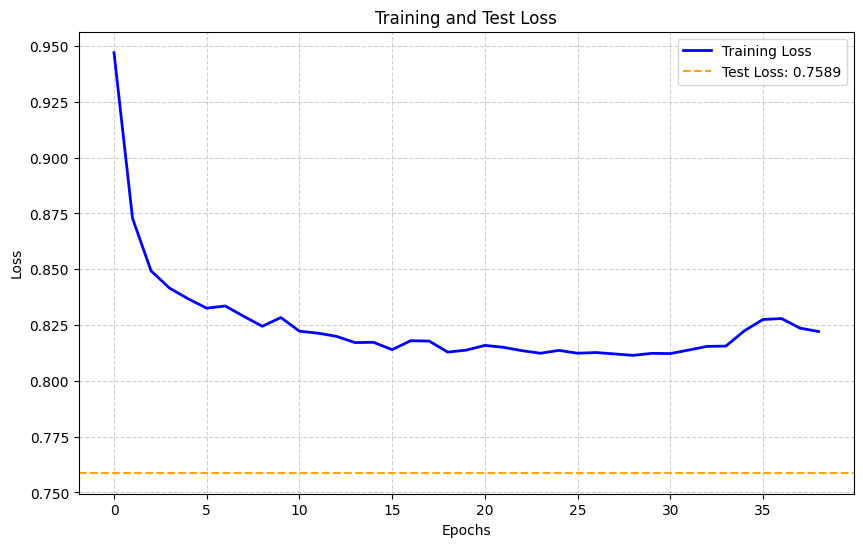

In [20]:
# Extract training loss
loss = history.history['loss']

# Evaluate test loss
test_loss, _ = model.evaluate(time_series_dataset.test, verbose=0)

# Plot training loss and test loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss', color='blue', linewidth=2)
plt.axhline(y=test_loss, color='orange', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

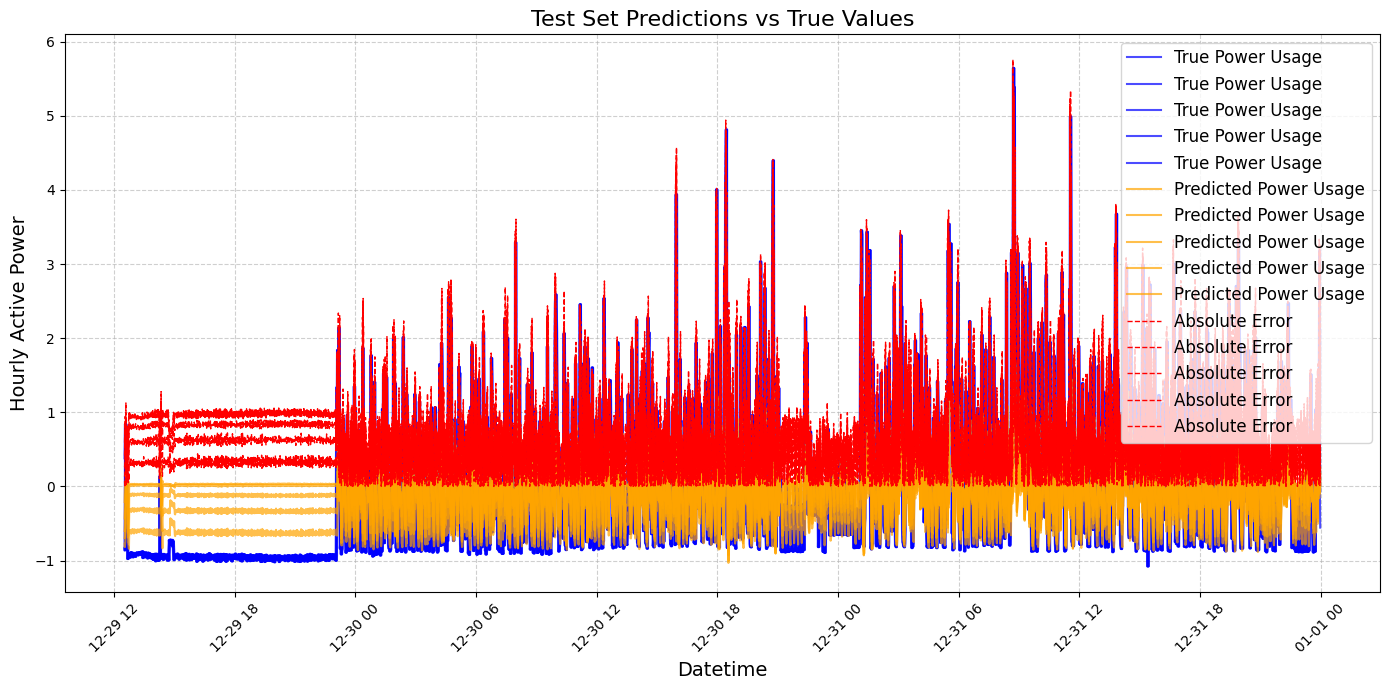

In [23]:
absolute_error = np.abs(test_labels - test_predictions)

datetime_test = data['Datetime'][-len(test_labels):]
plt.figure(figsize=(14, 7))
plt.plot(datetime_test, test_labels, label='True Power Usage', color='blue', linewidth=1.5, alpha=0.7)
plt.plot(datetime_test, test_predictions, label='Predicted Power Usage', color='orange', linewidth=1.5, alpha=0.7)
plt.plot(datetime_test, absolute_error, label='Absolute Error', color='red', linestyle='--', linewidth=1)

# Add labels, title, legend, and grid
plt.title('Test Set Predictions vs True Values', fontsize=16)
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Hourly Active Power', fontsize=14)
plt.legend(fontsize=12, loc='upper right')  # Ensure a single legend with proper placement
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

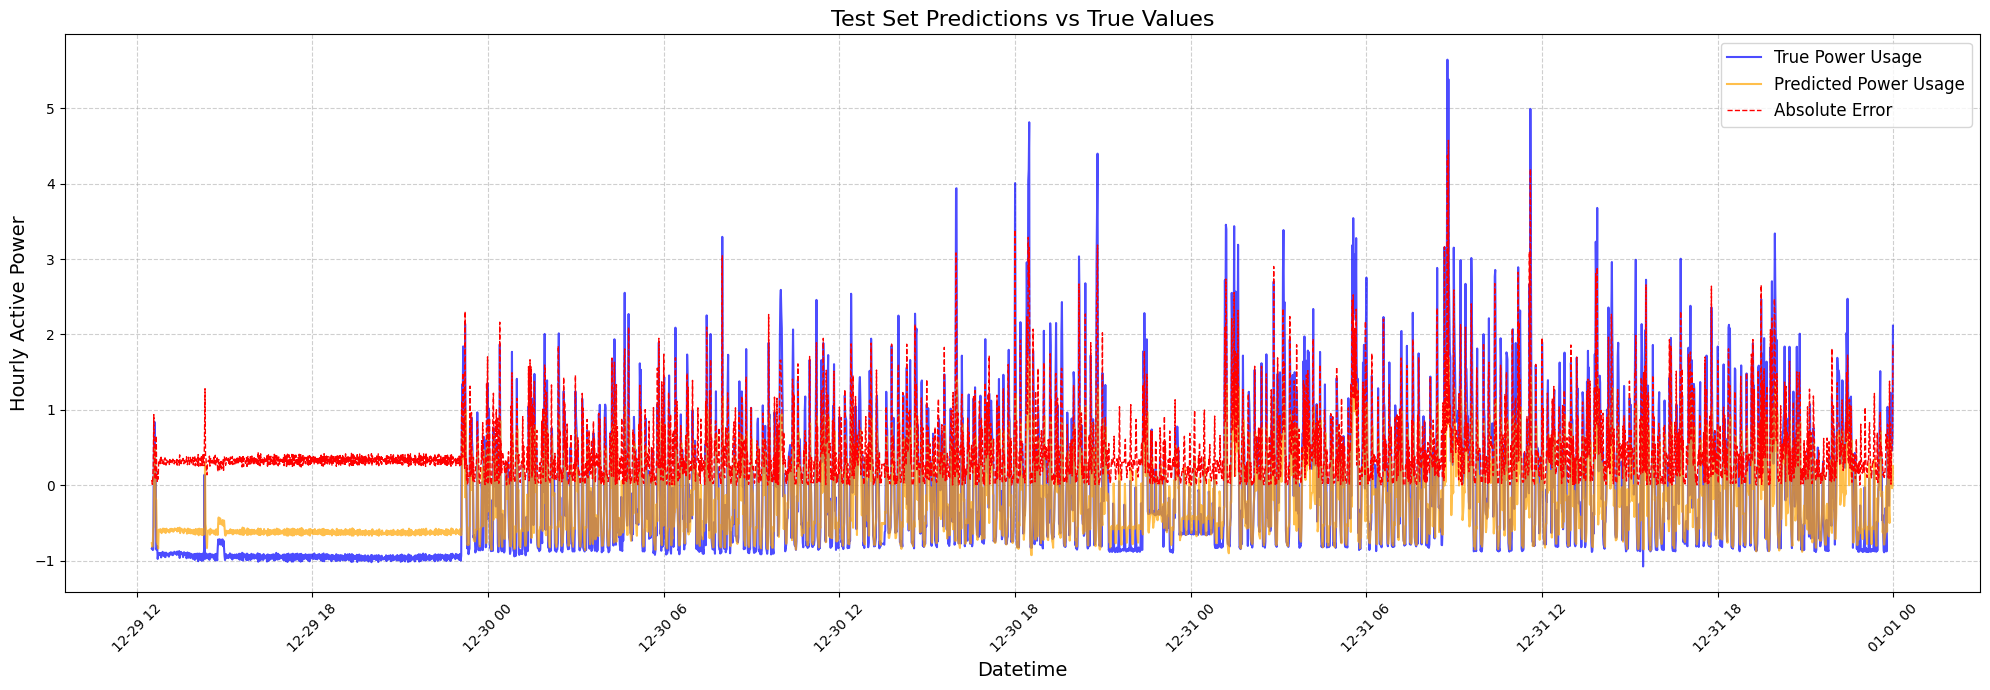

In [24]:
test_labels_1d = test_labels[:, 0]  # Select the first timestep from each sequence
test_predictions_1d = test_predictions[:, 0]

# Assuming test_labels_1d, test_predictions_1d, and datetime_test are defined
absolute_error = np.abs(test_labels_1d - test_predictions_1d)

plt.figure(figsize=(20, 7))

# Plot each data type
line1, = plt.plot(datetime_test, test_labels_1d, label='True Power Usage', color='blue', linewidth=1.5, alpha=0.7)
line2, = plt.plot(datetime_test, test_predictions_1d, label='Predicted Power Usage', color='orange', linewidth=1.5, alpha=0.7)
line3, = plt.plot(datetime_test, absolute_error, label='Absolute Error', color='red', linestyle='--', linewidth=1)

# Add a single legend
plt.legend(handles=[line1, line2, line3], fontsize=12, loc='upper right')

# Add labels, title, and grid
plt.title('Test Set Predictions vs True Values', fontsize=16)
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Hourly Active Power', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Ensure 'Date' is a datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Extract day and month for grouping
data['Day'] = data['Date'].dt.day
data['MonthYear'] = data['Date'].dt.to_period('M')  # Year-Month grouping

# Iterate through each unique Month-Year and plot
for month_year in data['MonthYear'].unique():
    # Subset the data for the current Month-Year
    monthly_data = data[data['MonthYear'] == month_year]

    # Create the box plot for each day of the month
    plt.figure(figsize=(12, 6))
    monthly_data.boxplot(column=PREDICTION_TERM, by='Day', grid=False, showfliers=False)
    plt.title(f'Box Plot for {month_year}')
    plt.suptitle('')  # Removes default subtitle
    plt.xlabel('Day of the Month')
    plt.ylabel('Values')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Save model
model.save('lstm_model.h5')

# # Load model
# from tensorflow.keras.models import load_model
# model = load_model('/kaggle/working/lstm_model.h5')